# 基于HDDM拟合2back任务

## 1.加载packages

In [1]:
import sys

print("Python 版本:", sys.version)

Python 版本: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:23:23) 
[GCC 10.3.0]


In [2]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## 2.导入数据集

In [3]:
! pip install openpyxl


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import hddm
import matplotlib.pyplot as plt
import seaborn as sns

# 读取 Excel 文件
file_path = './rawdata.xlsx'
trial_data = pd.read_excel(file_path)

# 清理列名中的空格
trial_data.columns = trial_data.columns.str.strip()

# 确保反应时间列 'rt' 被转换为浮点数类型
trial_data['rt'] = pd.to_numeric(trial_data['rt'], errors='coerce')

# 确保 'Group' 列的数据类型为字符串，并去除可能的空格
trial_data['Group'] = trial_data['Group'].astype(str).str.strip()

# 检查数据
print(trial_data.tail())
print(f"The number of trials: {trial_data.shape[0]}")
print(f"The number of variables: {trial_data.shape[1]}")
print(f"The number of participants: {trial_data['subj_idx'].unique().shape[0]}")

# 重新命名必要的列，确保与 HDDM 的要求一致
data = hddm.utils.flip_errors(trial_data)

# 数据检查完成，准备后续模型的构建

            ID  subj_idx  response     rt Group
21802  21570.0     19028         0  0.217     3
21803  21571.0     19028         1  0.172     3
21804  21572.0     19028         1  0.507     3
21805  21573.0     19028         1  0.339     3
21806  21574.0     19028         0  0.010     3
The number of trials: 21807
The number of variables: 5
The number of participants: 296


In [5]:
# 统计每个Group下各subj_idx的出现次数
group_counts = trial_data.groupby(['Group', 'subj_idx']).size().reset_index(name='Trial_Count')

# 保存统计结果为Excel
output_path = './被试trials刺激统计.xlsx'
group_counts.to_excel(output_path, index=False)

print(f"Group-wise subject trial counts saved to: {output_path}")

Group-wise subject trial counts saved to: ./被试trials刺激统计.xlsx


In [6]:
data=trial_data

In [ ]:
import matplotlib.pyplot as plt

# 分组标签映射（字符串类型）
group_labels = {
    '1': 'FES Patients',
    '2': 'ChSz Patients',
    '3': 'HC'  # 新增HC组
}

# 确保组的顺序为 ['1', '2', '3']
groups = ['1', '2', '3']

# 创建子图（这里将图像宽度适当增大以适应三个子图）
fig, axs = plt.subplots(1, len(groups), figsize=(12, 4), sharey=True, constrained_layout=True)

for idx, group in enumerate(groups):
    group_data = data[data['Group'] == group]
    ax = axs[idx]  # 当前子图
    ax.set_title(f"{group_labels[group]} RT Distribution", fontsize=14, weight='bold')
    
    # 绘制每个 subj_idx 的反应时间分布
    for subj_idx, subj_data in group_data.groupby('subj_idx'):
        subj_data.rt.hist(bins=10, histtype='step', ax=ax, alpha=0.7)
    
    ax.set_xlabel('Reaction Time (second)', fontsize=12, weight='bold')
    if idx == 0:  # 仅在第一个子图中设置 Y 轴标签
        ax.set_ylabel('Count', fontsize=12, weight='bold')
    
    # 添加网格线
    ax.grid(axis='both', linestyle='--', alpha=0.45)

# 保存图像
plt.savefig('rt_distributions_by_group_with_grid.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [8]:
# 检查 Group 列的唯一值及其数据类型
print(data['Group'].unique())
print(data['Group'].dtype)

# 确保 Group 列的值为字符串类型，并移除可能存在的空格
data['Group'] = data['Group'].astype(str).str.strip()

# 计算 Group 1、Group 2 和 Group 3 中的唯一被试数量
unique_group1_subjects = data[data['Group'] == '1']['subj_idx'].nunique()
unique_group2_subjects = data[data['Group'] == '2']['subj_idx'].nunique()
unique_group3_subjects = data[data['Group'] == '3']['subj_idx'].nunique()

print(f"First episode of schizophrenia = {unique_group1_subjects}")
print(f"Chronic schizophrenia = {unique_group2_subjects}")
print(f"HC subjects = {unique_group3_subjects}")

['1' '2' '3']
object
First episode of schizophrenia = 103
Chronic schizophrenia = 108
HC subjects = 85


#### 1.模型设计

In [9]:
# 基础模型（m0）：包含所有核心参数和变异性参数，不考虑条件或组别
m0 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'sz', 'st']
)

# 综合模型（m1）：分层模型，假设核心参数依赖于组别（Group）
m1 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    depends_on={
        'a': ['Group'], 
        'v': ['Group'], 
        't': ['Group'],
        'z': ['Group']
    }
)

# 回归模型：以健康对照组（组3）为参考组
m2v = hddm.HDDMRegressor(
    data,
    "v ~ 1 + C(Group, Treatment('3'))",  # 漂移率 v 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

m2z = hddm.HDDMRegressor(
    data,
    "z ~ 1 + C(Group, Treatment('3'))",  # 起始点 z 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

m2a = hddm.HDDMRegressor(
    data,
    "a ~ 1 + C(Group, Treatment('3'))",  # 决策界限 a 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

m2t = hddm.HDDMRegressor(
    data,
    "t ~ 1 + C(Group, Treatment('3'))",  # 非决策时间 t 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)


print('ok')

No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
ok


#### 2.模型拟合参数量 

In [10]:
def run_sampling(
    m,
    n_samples=15000,  # 10,000
    n_burn=5000,     # 5000
    n_chains=3,      # 4
    thin=2,  # Thinning：每隔2个样本保留1个
    model_name="m",
    progress_bar=True
):
    m_infdata = m.sample(
        n_samples,
        burn=n_burn,
        chains=n_chains,
        return_infdata=True,
        save_name="8.model_fitted/" + model_name,
        progress_bar=progress_bar
    )

    return m, m_infdata


# 计算时间估计
print('拟合参数设置成功!')

拟合参数设置成功!


In [ ]:
import time
import dill as pickle  # 使用dill代替pickle

# 模型和名称列表
models = [m2t]
model_names = ["m2t"]

# 创建一个字典存储结果
results = {}

for model, name in zip(models, model_names):
    print(f"Running model {name}... 🏃🏃🏃")
    start_time = time.time()
    
    # 运行采样
    model, model_infdata = run_sampling(model, model_name=name)
    elapsed_time = time.time() - start_time
    
    # 保存模型和结果
    with open(f'./2.模型拟合-输出/{name}_model.pkl', 'wb') as f_model:
        pickle.dump(model, f_model)
        
    with open(f'./2.模型拟合-输出/{name}_infdata.pkl', 'wb') as f_infdata:
        pickle.dump(model_infdata, f_infdata)
    
    results[name] = (model, model_infdata)
    
    print(f"Model {name} completed in {elapsed_time:.2f} seconds.\n")
    print(f"Model {name} and inference data saved as {name}_model.pkl and {name}_infdata.pkl.\n")

print('模型训练全部完成 😂!')

**注：在配备 2.90GHz 英特尔®酷睿™i7-10700 处理器的电脑上，用上述设置（10000 个样本）拟合所有这六个模型大约需要 8-9 个小时。此外，内存应足够大，建议使用 ~ 64 G 内存。否则，建议使用少量样本（如 n_samples=2500，burn=1000）。

#### 3.读取之前好的模型😂

In [11]:
import pickle

# 模型和推断数据的文件名
model_names = ["m2t"] 
 
# 创建字典存储模型和推断数据
models = {}
infdata = {}

# 加载所有模型和推断数据
for name in model_names:
    model_file_path = f'./2.模型拟合-输出/{name}_model.pkl'
    infdata_file_path = f'./2.模型拟合-输出/{name}_infdata.pkl'
    
    # 重新加载模型
    with open(model_file_path, 'rb') as f_model:
        models[name] = pickle.load(f_model)
    
    # 重新加载推断数据
    with open(infdata_file_path, 'rb') as f_infdata:
        infdata[name] = pickle.load(f_infdata)
    
    # 动态赋值回原始变量名
    globals()[name] = models[name]
    globals()[f"{name}_infdata"] = infdata[name]
    
    print(f"{name} 已经成功挂载!")

# 打印已加载的模型和推断数据
for name in model_names:
    print(f"{name} 模型:", globals()[name])
    print(f"{name} 推断数据:", globals()[f"{name}_infdata"])

print('所有模型和推断数据读取成功!😂')

m2t 已经成功挂载!
m2t 模型: <hddm.models.hddm_regression.HDDMRegressor object at 0xffff94fc5730>
m2t 推断数据: Inference data with groups:
	> posterior
	> observed_data
所有模型和推断数据读取成功!😂


In [12]:
import pickle

# 定义模型名称列表
model_names = ["m2t"]
posterior_distributions = {}

# 循环加载每个模型并提取后验分布
for model_name in model_names:
    print(f"提取 {model_name} 的后验分布...")
    
    # 加载模型
    with open(f'./2.模型拟合-输出/{model_name}_model.pkl', 'rb') as f_model:
        model_loaded = pickle.load(f_model)
    
    # 提取后验分布
    posterior_samples = model_loaded.get_traces()
    
    # 将每个模型的后验分布存储在字典中
    posterior_distributions[model_name] = posterior_samples
    
    # 打印提取的后验分布的前几行
    print(f"{model_name}的后验分布提取完成:")

print("所有模型的后验分布提取完成！😂")


#得20分钟

提取 m2t 的后验分布...
m2t的后验分布提取完成:
所有模型的后验分布提取完成！😂


#### 4.查看内存

In [13]:
import psutil
print(f"Available memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Available memory: 4.65 GB


## 3.模型诊断

In [ ]:
import arviz as az
import pandas as pd

# 获取每个模型中存储的变量名称并排除含有 'subj' 的变量
model_data = {}
filtered_model_data = {}

# 模型 m0 到 m4 的变量存储
for i, infdata in enumerate([m0_infdata]):
    model_name = f'm{i}'  # m0, m1, m2, m3, m4
    # 获取变量名称
    var_names = list(infdata.posterior.data_vars)
    model_data[model_name] = var_names
    
    # 排除包含 'subj' 的变量
    filtered_var_names = [var for var in var_names if 'subj' not in var]
    filtered_model_data[model_name] = filtered_var_names

# 将完整数据转换为 DataFrame 并保存到 Excel
df_model_data = pd.DataFrame.from_dict(model_data, orient='index').transpose()
df_model_data.to_excel('3.模型诊断-输出/model_variables_full.xlsx', index=False)

# 将排除含有 'subj' 的数据保存到另一个 Excel
df_filtered_model_data = pd.DataFrame.from_dict(filtered_model_data, orient='index').transpose()
df_filtered_model_data.to_excel('3.模型诊断-输出/model_variables_filtered.xlsx', index=False)

# 打印过滤后的模型变量名称
print('保存完成！')

#### （1）方法1.Trace plot

We can also only plot selected parameters' traces. 
 
- use regex to select var_names that start with "a" and do not contain either "subj" or "std".

print(tmp_infdata.posterior.dims)
print(tmp_infdata.posterior.coords)
print(tmp_infdata.posterior.data_vars)##### M0

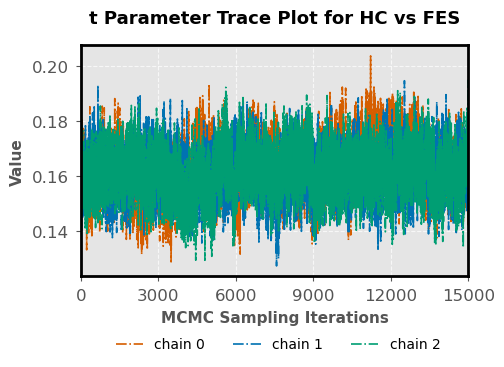

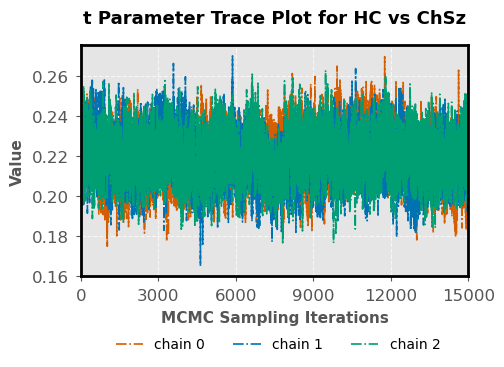

In [23]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表修改为 m2t
model_names = ['m2t']  

# 定义需要检查的两个参数（根据要求）
parameters = ["t_C(Group, Treatment(\'3\'))[T.1]", "t_C(Group, Treatment(\'3\'))[T.2]"]

# 自定义 chain 颜色（为3个链设置颜色）
chain_colors = ['#D55E00', '#0072B2', '#009E73']  # Nature 风格配色

# 设置这两个参数对应的组信息，更新为具体比较信息
model_patient_groups = {
    "t_C(Group, Treatment(\'3\'))[T.1]": "HC vs FES",
    "t_C(Group, Treatment(\'3\'))[T.2]": "HC vs ChSz"
}

# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据，此处假设变量名为 m2t_infdata
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 直接使用参数名称
        var_name = param

        # 提取参数前缀作为简化显示的名称（例如提取“t_C”）
        param_clean = var_name.split('(')[0]
        # 如果参数名称为 t_C，则仅显示 t
        if param_clean == "t_C":
            param_clean = "t"

        # 手动绘制每个链的轨迹
        fig, ax = plt.subplots(figsize=(5, 3))

        # 手动绘制每条链
        for i, color in enumerate(chain_colors):
            chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
            ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
        
        # 设置 X 轴刻度：0 ~ 15000, 间隔 2000
        ax.set_xlim(0, 15000)
        ax.set_xticks(range(0, 15001, 3000))
        
        # 添加 X 轴和 Y 轴标签，并设置字体为粗体
        ax.set_xlabel("MCMC Sampling Iterations", fontsize=11, fontweight='bold', labelpad=5)
        ax.set_ylabel("Value", fontsize=11, fontweight='bold', labelpad=5)

        # 获取患者组信息，并生成合适的标题
        patient_group = model_patient_groups.get(param, 'Unknown group')
        ax.set_title(f'{param_clean} Parameter Trace Plot for {patient_group}', fontsize=13, fontweight='bold', y=1.06)

        # 设置边框颜色为黑色，并加粗
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(2)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=10, frameon=False, ncol=4, fancybox=True, bbox_to_anchor=(0.96, -0.21))

        # 保存每个参数的 Trace Plot，确保文件名包含每个参数
        output_file_path = f'{output_folder}/{model_name}_{param}_trace_plot.jpg'
        plt.savefig(output_file_path, dpi=1200, format='jpg', bbox_inches='tight')
        plt.show()

#### （2）方法2. $\hat{R}$ and ESS

In [ ]:
import pandas as pd
import arviz as az

# 假设你已经在之前的代码中动态加载了推断数据
model_data = [m2t_infdata]  # 使用正确的全局变量名
model_names = ['m2t']

# 循环处理每个模型
for model_name, tmp_infdata in zip(model_names, model_data):
    
    # 获取R-hat大于1.1的参数及其诊断统计量
    summary_tmp = az.summary(tmp_infdata, kind="diagnostics", round_to=4)
    problem_params = summary_tmp[summary_tmp["r_hat"] > 1.1]

    # 打印问题参数
    print(f"问题参数😭 - {model_name}:")
    print(problem_params)

    # 将问题参数保存为Excel文件
    problem_params.to_excel(f"3.模型诊断-输出/problem_params-{model_name}.xlsx", index=True)
    print(f"已成功将问题参数保存至 problem_params-{model_name}.xlsx 文件")

    # 获取R-hat小于等于1.1的参数
    good_params = summary_tmp[summary_tmp["r_hat"] <= 1.1]

    # 打印收敛良好的参数
    print(f"收敛良好的参数😂 - {model_name}:")
    print(good_params)

    # 将收敛良好的参数保存为Excel文件
    good_params.to_excel(f"3.模型诊断-输出/good_params-{model_name}.xlsx", index=True)
    print(f"已成功将收敛良好的参数保存至 good_params-{model_name}.xlsx 文件")

    # 只计算 ESS
    ess_values = az.ess(tmp_infdata).values
    print(f"模型 {model_name} 的 ESS 值：")
    print(ess_values)


## 4. 模型比较与选择 (基于DIC)

In [ ]:
! pip3 install tabulate

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 模拟DIC数据，使用模型的具体名称
dic_dict = {
    "Model 1": m0.dic,
    "Model 0": m1.dic,
}

# 将字典转换为Pandas DataFrame,并按照DIC值升序排序
comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic = comp_dic.sort_values(by=['DIC'], ascending=True)

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

# 设置绘图风格，使用符合Nature风格的简洁主题
sns.set(style="whitegrid", font_scale=1.2)

# 创建颜色映射，颜色越大越深
norm = plt.Normalize(comp_dic['DIC'].min(), comp_dic['DIC'].max())
colors = plt.cm.viridis(norm(comp_dic['DIC']))  # 使用 vivid 色彩映射

# 创建柱状图，将 X 和 Y 轴对调
plt.figure(figsize=(6, 5))
bar_plot = sns.barplot(y='model', x='DIC', data=comp_dic, palette=colors)

# 为柱状图中的每个柱子设置透明度、边框粗细和花纹
for patch in bar_plot.patches:
    patch.set_alpha(0.7)  # 设置透明度为0.7
    patch.set_edgecolor('black')  # 设置边框颜色为黑色
    patch.set_linewidth(0.6)  # 设置边框粗细为0.6
    patch.set_hatch('/')  # 设置花纹，'/'表示斜线

# 在柱子上标注具体数值
for i, patch in enumerate(bar_plot.patches):
    width = patch.get_width()
    bar_plot.text(width + 0.5,  # 数值标签的x坐标稍高于柱子顶部
                  patch.get_y() + patch.get_height() / 2,
                  f'{width:.2f}',  # 显示2位小数
                  ha='left', 
                  va='center', 
                  fontsize=8, 
                  weight='bold')

# 添加图形标题和坐标轴标签
bar_plot.set_ylabel("Model", fontsize=12, weight='bold')
bar_plot.set_xlabel("DIC Value", fontsize=12, weight='bold')

# 调整标签和风格，参考Nature风格
bar_plot.tick_params(axis='both', which='major', labelsize=12)
bar_plot.spines['top'].set_visible(False)
bar_plot.spines['right'].set_visible(False)

# 设置左和底部的边框为黑色，并加粗
bar_plot.spines['left'].set_linewidth(1.5)
bar_plot.spines['left'].set_color('black')  # 改为黑色
bar_plot.spines['bottom'].set_linewidth(2)
bar_plot.spines['bottom'].set_color('black')  # 改为黑色

# 设置网格线的透明度和粗细
bar_plot.grid(True, which='major', axis='x', linestyle='-.', linewidth=0.8, alpha=0.8)  # 现在对x轴应用网格线
bar_plot.grid(True, which='major', axis='y', linestyle='-.', linewidth=0.8, alpha=0.8)

# 调整布局以防止标签被截断
plt.tight_layout()

# 保存图片到指定文件夹，并确保不会截断图像
plt.savefig("4.模型比较-输出/DIC_comparison.jpeg", dpi=600, format='jpeg', bbox_inches='tight')  # 使用bbox_inches='tight'来防止截断

# 显示图形
plt.show()

In [ ]:
# 计算模型间的 DIC 差异
comp_dic['ΔDIC'] = comp_dic['DIC'] - comp_dic['DIC'].min()

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

## 5. 统计推断

### 1.查看字段 + 输出后验参数

In [ ]:
import pandas as pd
import numpy as np

# 只使用m1模型
model = m1_infdata  # 直接使用m1模型，不需要列表

# 创建一个 Excel writer
with pd.ExcelWriter('6.统计推断-输出/models_infdata_posterior_means-m1.xlsx') as writer:
    try:
        # 获取后验样本
        posterior_samples = model.posterior
        
        # 创建存储结果的字典
        results_dict = {}
        
        # 遍历posterior中的所有变量
        for var_name in posterior_samples.keys():
            # 检查是否是个体参数（包含subj字样）
            if 'subj' in var_name:
                # 提取参数类型（如 'a', 'v', 't', 'z'）
                param_type = var_name.split('.')[0]
                # 提取被试编号
                subj = var_name.split('.')[-1]
                
                # 计算后验均值
                posterior_mean = posterior_samples[var_name].values.mean()
                
                # 存储结果
                if subj not in results_dict:
                    results_dict[subj] = {}
                results_dict[subj][param_type] = posterior_mean
        
        # 只有在有数据时才创建DataFrame和写入Excel
        if results_dict:
            # 转换为DataFrame
            df = pd.DataFrame.from_dict(results_dict, orient='index')
            df.index.name = 'subject'
            
            # 写入Excel
            df.to_excel(writer, sheet_name='m1_posterior_means')
            print("m1模型: 写入成功！")
        else:
            print("m1模型: 没有找到个体参数数据")
        
    except Exception as e:
        print(f"写入失败！错误信息：{e}")

print("存储完成！")

### 2.查看参数

In [ ]:
models = [m1]
model_names = ["m1"]

for i, model in enumerate(models):
    print(f"{model_names[i]} nodes_db columns:")
    print(model.nodes_db.columns)
    print("\n" + "="*50 + "\n")

### 3.是否在Group存在显著差异

#### v参数

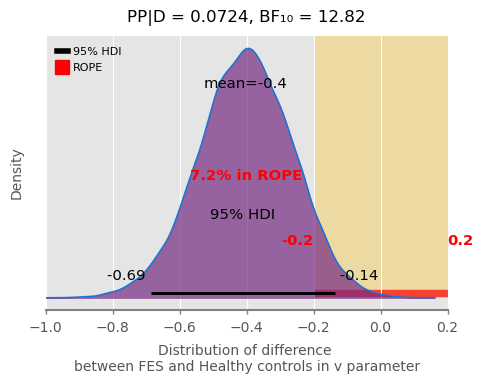

┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │
├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤
│ v_C(Group, │          -0.4023 │          -0.6863 │          -0.1357 │     0.0724 │   12.82 │
└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘


In [20]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')  # 更换图风格为 'ggplot'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数（FES vs Healthy）
model_data = {
    'm2v': ('v_C(Group, Treatment(\'3\'))[T.1]', m2v_infdata)
}

# 创建单行图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 4))  # 单个子图

# 存储结果的列表
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算后验分布的均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.2) & (posterior_samples < 0.2)).mean()

    # 计算 BF_{10}
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘制后验分布图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.2, 0.2],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取x和y坐标，用于填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()

    # 使用 fill_between 方法进行填充
    axes.fill_between(x_vals, y_vals, color='#762a83', alpha=0.7)

    # 设置图形格式
    axes.set_xlim(-1, 0.2)  # 根据数据范围调整 X 轴范围
    axes.set_xlabel('Distribution of difference \nbetween FES and Healthy controls in v parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_diff:.4f}, BF₁₀ = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 添加填充矩形表示 ROPE 区域
    rect = plt.Rectangle((-0.2, 0), 0.4, axes.get_ylim()[1], 
                         linewidth=0, facecolor='#FFC107', alpha=0.3,
                         zorder=-1)
    axes.add_patch(rect)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]

    # 添加图例
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=8, 
                frameon=False, edgecolor='none', fancybox=False, 
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/t_C_Group_Treatment_3_vs_FES_Healthy_m2v.jpg', dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 打印为三线表格式
print("┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │")
print("├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>16} │ {row['95% HDI Lower']:>16} │ {row['95% HDI Upper']:>16} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘")

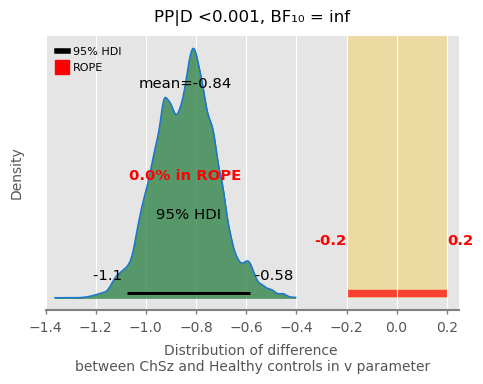

┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │
├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤
│ v_C(Group, │          -0.8415 │          -1.0769 │          -0.5831 │     <0.001 │     inf │
└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘


In [25]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数（ChSz vs Healthy）在 t 参数上
model_data = {
    'm2v': ('v_C(Group, Treatment(\'3\'))[T.2]', m2v_infdata)
}

# 创建图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 4))  # 单个子图

# 存储结果
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D
    ppd_diff = ((posterior_samples > -0.2) & (posterior_samples < 0.2)).mean()

    # 计算贝叶斯因子 BF₁₀
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.2, 0.2],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 高亮曲线下方
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()
    axes.fill_between(x_vals, y_vals, color='#1b7837', alpha=0.7)

    axes.set_xlim(-1.4, 0.25)
    axes.set_xlabel(
        'Distribution of difference \nbetween ChSz and Healthy controls in v parameter',
        fontsize=10, labelpad=6
    )
    axes.set_ylabel('Density', fontsize=10, labelpad=12)

    # 如果 PP|D < 0.001，则显示 "<0.001"
    display_ppd = "<0.001" if ppd_diff < 0.001 else f"{ppd_diff:.4f}"
    axes.set_title(
        f'PP|D {display_ppd}, BF₁₀ = {bf_10_diff:.2f}',
        fontsize=12, pad=10
    )

    # 绘制 ROPE 区域
    rect = plt.Rectangle(
        (-0.2, 0), 0.4, axes.get_ylim()[1],
        linewidth=0, facecolor='#FFC107', alpha=0.3, zorder=-1
    )
    axes.add_patch(rect)

    # 自定义图例
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),
        Line2D([0], [0], color='red', marker='s', markersize=10,
               linestyle='None')
    ]
    axes.legend(
        custom_lines, ["95% HDI", "ROPE"],
        loc='upper left', fontsize=8,
        frameon=False, edgecolor='none',
        fancybox=False, borderpad=0.5,
        handlelength=1.0, handletextpad=0.5
    )

    # 存储结果（保留原始数值）
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 保存和展示图像
plt.tight_layout()
plt.savefig(
    '6.统计推断-输出/组间差异/t_C_Group_Treatment_3_vs_ChSz_Healthy_m2v.jpg',
    dpi=1200, bbox_inches='tight', transparent=True
)
plt.show()

# 打印结果三线表
df_results = pd.DataFrame(results)

# 格式化其它列
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 对 PP|D 列做条件格式
df_results['PP|D'] = df_results['PP|D'].apply(
    lambda x: "<0.001" if x < 0.001 else f"{x:.4f}"
)

# 输出三线表
print("┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │")
print("├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤")
for _, row in df_results.iterrows():
    print(
        f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>16} │ "
        f"{row['95% HDI Lower']:>16} │ {row['95% HDI Upper']:>16} │ "
        f"{row['PP|D']:>10} │ {row['BF_{10}']:>7} │"
    )
print("└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘")

#### a参数

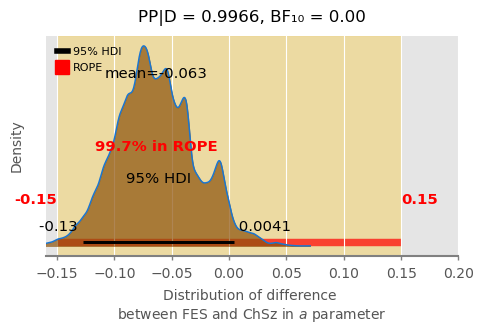

┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │
├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤
│ a_C(Group, │          -0.0632 │          -0.1276 │           0.0041 │     0.9966 │    0.00 │
└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘


In [14]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')  # 更换图风格为 'ggplot'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数（FES vs Healthy）
model_data = {
    'm2a': ('a_C(Group, Treatment(\'3\'))[T.1]', m2a_infdata)
}

# 创建单行图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 3.5))  # 单个子图

# 存储结果的列表
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算后验分布的均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.15) & (posterior_samples < 0.15)).mean()

    # 计算 BF_{10}
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘制后验分布图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.15, 0.15],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取 x 和 y 坐标，用于填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()

    # 使用 fill_between 方法进行填充
    axes.fill_between(x_vals, y_vals, color='#8c510a', alpha=0.7)

    # 设置图形格式
    axes.set_xlim(-0.16, 0.2)  # 根据数据范围调整 X 轴范围
    axes.set_xlabel('Distribution of difference \nbetween FES and ChSz in $a$ parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_diff:.4f}, BF₁₀ = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 使用 axvspan 绘制 ROPE 阴影，确保颜色和透明度与你期望一致
    axes.axvspan(-0.15, 0.15, color='#FFC107', alpha=0.3, zorder=-1)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]
    # 添加图例
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=8,
                frameon=False, edgecolor='none', fancybox=False,
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/t_C_Group_Treatment_3_vs_FES_Healthy_m2a.jpg',
            dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 打印为三线表格式
print("┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │")
print("├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>16} │ {row['95% HDI Lower']:>16} │ {row['95% HDI Upper']:>16} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘")

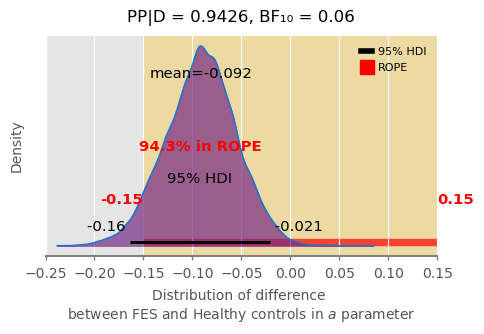

┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │
├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤
│ a_C(Group, │          -0.0916 │          -0.1636 │          -0.0212 │     0.9426 │    0.06 │
└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘


In [15]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数（ChSz vs Healthy）在 a 参数上
model_data = {
    'm2a': ('a_C(Group, Treatment(\'3\'))[T.2]', m2a_infdata)
}

# 创建图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 3.5))  # 单个子图

# 存储结果
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 反转后验样本的符号，使得计算结果为 ChSz - Healthy controls 的差异
    posterior_samples = -posterior_samples

    # 计算均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（判断差异是否接近 0）
    ppd_diff = ((posterior_samples > -0.15) & (posterior_samples < 0.15)).mean()

    # 计算贝叶斯因子 BF₁₀
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 定义 PP|D 的字符串显示格式：当小于 0.001 时显示为 "<0.001"
    ppd_str = "<0.001" if ppd_diff < 0.001 else f"{ppd_diff:.4f}"

    # 绘图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.15, 0.15],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取后验分布的 x 和 y 坐标数据，并使用 fill_between 进行填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()
    axes.fill_between(x_vals, y_vals, color='#762a83', alpha=0.7)

    # 设置 x 轴范围、标签及标题
    axes.set_xlim(-0.25, 0.15)
    axes.set_xlabel('Distribution of difference \nbetween FES and Healthy controls in $a$ parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_str}, BF₁₀ = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 获取当前 y 轴范围，并绘制 ROPE 区域的矩形（横坐标[-0.15, 0.15]，宽度为 0.3）
    ymin, ymax = axes.get_ylim()
    rect = plt.Rectangle(
        (-0.15, ymin),       # 左下角坐标
        0.3,                 # 宽度（0.15 - (-0.15) = 0.3）
        ymax - ymin,         # 高度
        linewidth=0,
        facecolor='#FFC107',
        alpha=0.3,
        zorder=-1
    )
    axes.add_patch(rect)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper right', fontsize=8,
                frameon=False, edgecolor='none', fancybox=False,
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 保存和展示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/t_C_Group_Treatment_3_vs_ChSz_Healthy_m2at.jpg', dpi=1200, bbox_inches='tight', transparent=True)
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值处理
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].apply(lambda x: "<0.001" if x < 0.001 else f"{x:.4f}")
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

print("┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │")
print("├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>16} │ {row['95% HDI Lower']:>16} │ {row['95% HDI Upper']:>16} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘")

#### t参数

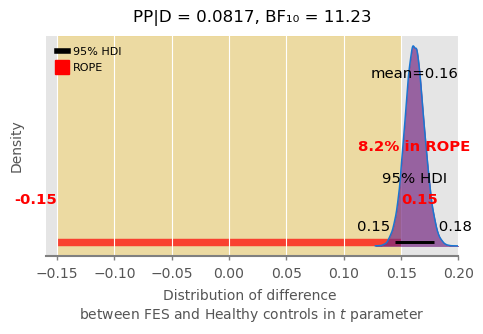

┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │
├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤
│ t_C(Group, │           0.1617 │           0.1450 │           0.1789 │     0.0817 │   11.23 │
└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘


In [14]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')  # 更换图风格为 'ggplot'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数（FES vs Healthy）
model_data = {
    'm2t': ('t_C(Group, Treatment(\'3\'))[T.1]', m2t_infdata)
}

# 创建单行图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 3.5))  # 单个子图

# 存储结果的列表
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算后验分布的均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.15) & (posterior_samples < 0.15)).mean()

    # 计算 BF_{10}
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘制后验分布图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.15, 0.15],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取 x 和 y 坐标，用于填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()

    # 使用 fill_between 方法进行填充
    axes.fill_between(x_vals, y_vals, color='#762a83', alpha=0.7)

    # 设置图形格式
    axes.set_xlim(-0.16, 0.2)  # 根据数据范围调整 X 轴范围
    axes.set_xlabel('Distribution of difference \nbetween FES and Healthy controls in $t$ parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_diff:.4f}, BF₁₀ = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 使用 axvspan 绘制 ROPE 阴影，确保颜色和透明度与你期望一致
    axes.axvspan(-0.15, 0.15, color='#FFC107', alpha=0.3, zorder=-1)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]
    # 添加图例
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=8,
                frameon=False, edgecolor='none', fancybox=False,
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/t_C_Group_Treatment_3_vs_FES_Healthy_m2t.jpg',
            dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 打印为三线表格式
print("┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │")
print("├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>16} │ {row['95% HDI Lower']:>16} │ {row['95% HDI Upper']:>16} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘")

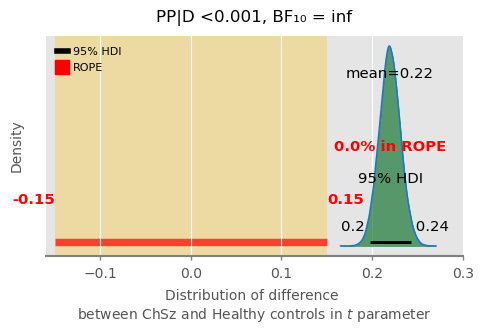

┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │
├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤
│ t_C(Group, │           0.2194 │           0.1970 │           0.2429 │     <0.001 │     inf │
└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘


In [13]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数（ChSz vs Healthy）在 t 参数上
model_data = {
    'm2t': ('t_C(Group, Treatment(\'3\'))[T.2]', m2t_infdata)
}

# 创建图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 3.5))  # 单个子图

# 存储结果
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.15) & (posterior_samples < 0.15)).mean()

    # 计算贝叶斯因子 BF₁₀
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 定义 PP|D 的字符串显示格式：当小于 0.001 时显示为 "<0.001"
    ppd_str = "<0.001" if ppd_diff < 0.001 else f"{ppd_diff:.4f}"

    # 绘图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.15, 0.15],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取后验分布的 x 和 y 坐标数据，并使用 fill_between 进行填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()
    axes.fill_between(x_vals, y_vals, color='#1b7837', alpha=0.7)

    # 设置 x 轴范围及标签、标题
    axes.set_xlim(-0.16, 0.3)
    axes.set_xlabel('Distribution of difference \nbetween ChSz and Healthy controls in $t$ parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D {ppd_str}, BF₁₀ = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 获取当前 y 轴范围，并绘制 ROPE 区域的矩形（横坐标[-0.15, 0.15]，宽度为 0.3）
    ymin, ymax = axes.get_ylim()
    rect = plt.Rectangle(
        (-0.15, ymin),       # 左下角坐标
        0.3,                 # 宽度（0.15 - (-0.15) = 0.3）
        ymax - ymin,         # 高度
        linewidth=0,
        facecolor='#FFC107',
        alpha=0.3,
        zorder=-1
    )
    axes.add_patch(rect)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
    ]
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=8, 
                frameon=False, edgecolor='none', fancybox=False, 
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 保存和展示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/t_C_Group_Treatment_3_vs_ChSz_Healthy_m2t.jpg', dpi=1200, bbox_inches='tight', transparent=True)
plt.show()

# 打印结果三线表
df_results = pd.DataFrame(results)

# 格式化数值处理
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
# 对 PP|D 如果小于 0.001 则标注为 "<0.001"，否则按照四位小数格式化
df_results['PP|D'] = df_results['PP|D'].apply(lambda x: "<0.001" if x < 0.001 else f"{x:.4f}")
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

print("┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │")
print("├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>16} │ {row['95% HDI Lower']:>16} │ {row['95% HDI Upper']:>16} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘")

#### z参数

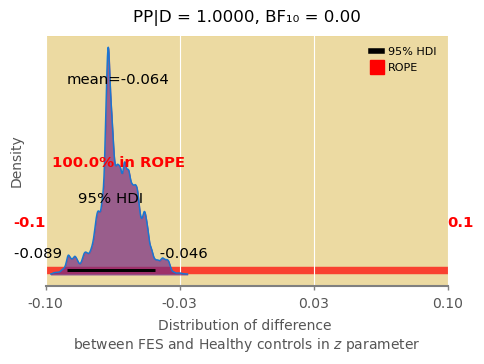

┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │
├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤
│ z_C(Group, │          -0.0639 │          -0.0892 │          -0.0456 │     1.0000 │    0.00 │
└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘


In [14]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')  # 更换图风格为 'ggplot'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数（FES vs Healthy）
model_data = {
    'm2z': ('z_C(Group, Treatment(\'3\'))[T.1]', m2z_infdata)
}

# 创建单行图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 3.8))  # 单个子图

# 存储结果的列表
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算后验分布的均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.1) & (posterior_samples < 0.1)).mean()

    # 计算 BF_{10}
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘制后验分布图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.1, 0.1],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取 x 和 y 坐标，用于填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()

    # 使用 fill_between 方法进行填充
    axes.fill_between(x_vals, y_vals, color='#762a83', alpha=0.7)


    
    axes.set_xlim(-0.1, 0.1)
    ticks = np.linspace(-0.1, 0.1, 4)  # 生成4个均分的刻度
    axes.set_xticks(ticks)
    axes.set_xticklabels(["{:.2f}".format(tick) for tick in ticks])

    
    axes.set_xlabel('Distribution of difference \nbetween FES and Healthy controls in $z$ parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_diff:.4f}, BF₁₀ = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 使用 axvspan 绘制 ROPE 阴影，确保颜色和透明度与你期望一致
    axes.axvspan(-0.1, 0.1, color='#FFC107', alpha=0.3, zorder=-1)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]
    # 添加图例
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper right', fontsize=8,
                frameon=False, edgecolor='none', fancybox=False,
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/t_C_Group_Treatment_3_vs_FES_Healthy_m2z.jpg',
            dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 打印为三线表格式
print("┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │")
print("├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>16} │ {row['95% HDI Lower']:>16} │ {row['95% HDI Upper']:>16} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘")

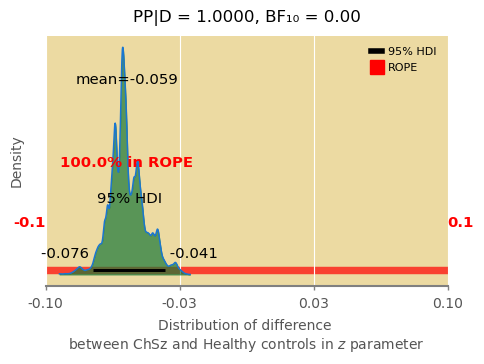

┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │
├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤
│ z_C(Group, │          -0.0595 │          -0.0762 │          -0.0406 │     1.0000 │    0.00 │
└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘


In [15]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数（ChSz vs Healthy）在 t 参数上
model_data = {
    'm2z': ('z_C(Group, Treatment(\'3\'))[T.2]', m2z_infdata)
}

# 创建图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 3.8))  # 单个子图

# 存储结果
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.1) & (posterior_samples < 0.1)).mean()

    # 计算贝叶斯因子 BF₁₀
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 定义 PP|D 的字符串显示格式：当小于 0.001 时显示为 "<0.001"
    ppd_str = "<0.001" if ppd_diff < 0.001 else f"{ppd_diff:.4f}"

    # 绘图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.1, 0.1],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取后验分布的 x 和 y 坐标数据，并使用 fill_between 进行填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()
    axes.fill_between(x_vals, y_vals, color='#1b7837', alpha=0.7)


    axes.set_xlim(-0.1, 0.1)
    ticks = np.linspace(-0.1, 0.1, 4)  # 生成4个均分的刻度
    axes.set_xticks(ticks)
    axes.set_xticklabels(["{:.2f}".format(tick) for tick in ticks])
    
    axes.set_xlabel('Distribution of difference \nbetween ChSz and Healthy controls in $z$ parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_str}, BF₁₀ = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 获取当前 y 轴范围，并绘制 ROPE 区域的矩形（横坐标[-0.15, 0.15]，宽度为 0.3）
    ymin, ymax = axes.get_ylim()
    rect = plt.Rectangle(
        (-0.1, ymin),       # 左下角坐标
        0.2,                 # 宽度（0.15 - (-0.15) = 0.3）
        ymax - ymin,         # 高度
        linewidth=0,
        facecolor='#FFC107',
        alpha=0.3,
        zorder=-1
    )
    axes.add_patch(rect)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
    ]
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper right', fontsize=8, 
                frameon=False, edgecolor='none', fancybox=False, 
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 保存和展示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/t_C_Group_Treatment_3_vs_ChSz_Healthy_m2z.jpg', dpi=1200, bbox_inches='tight', transparent=True)
plt.show()

# 打印结果三线表
df_results = pd.DataFrame(results)

# 格式化数值处理
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
# 对 PP|D 如果小于 0.001 则标注为 "<0.001"，否则按照四位小数格式化
df_results['PP|D'] = df_results['PP|D'].apply(lambda x: "<0.001" if x < 0.001 else f"{x:.4f}")
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

print("┌────────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference  │ 95% HDI Lower     │ 95% HDI Upper     │   PP|D     │ BF_{10} │")
print("├────────────┼──────────────────┼──────────────────┼──────────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>16} │ {row['95% HDI Lower']:>16} │ {row['95% HDI Upper']:>16} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴─────────┘")

In [16]:
print("代码全部完成!")

代码全部完成!
